Firstly, we calculate the first three eigenstates of Fluxonium qubit

$$H=4 E_{C} \hat{n}^{2}+\frac{1}{2} E_{L} \hat{\varphi}^{2}-E_{J} \cos \left(\hat{\varphi}-2 \pi \frac{\Phi_{\text {ext }}}{\Phi_{0}}\right)$$

In [2]:
import jax
from jax import jit, vmap, grad
from jax import random
import jax.numpy as jnp
from jax import vjp

from jax.experimental import ode, optimizers
from jax.experimental.ode import odeint

from jax.config import config  # Force Jax use float64 as default Float dtype
config.update("jax_enable_x64", True)

key = random.PRNGKey(42)

sx= jnp.array([[0,1],[1,0]],dtype=jnp.float64)

In [3]:
import numpy as np 
from scipy.linalg import eigh 

#we set mu = hbar = 1

#mesh of the finite difference 
xmin = -20; xmax = 20; Nmesh = 500
xmesh = jnp.linspace(xmin, xmax, Nmesh)

p0 = 0.5
Ej , Ec , El= 8.97, 2.47, 0.520
# Ec,El,Ej = 0.479, 0.132, 3.395

h = xmesh[1] - xmesh[0]


def buildH(p,Ec,El,Ej):
    Vx = jnp.array([0.5*El*x**2-Ej*jnp.cos(x-2*jnp.pi*p) for x in xmesh])
    H = jnp.diag(Vx) 
    return H + 2*jnp.eye(Nmesh)*(Ec*4/(h*h))- 4*(jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h)

energies: [-0.61053641 -0.25549677  8.78300117 11.71459067]
E = 0.0


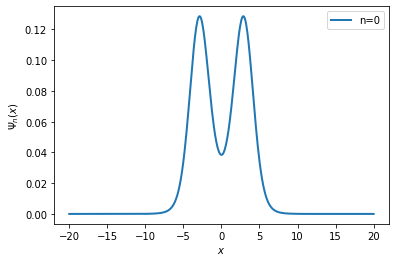

E = 0.3550396372536511


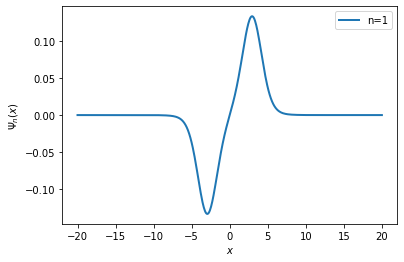

E = 9.393537579794367


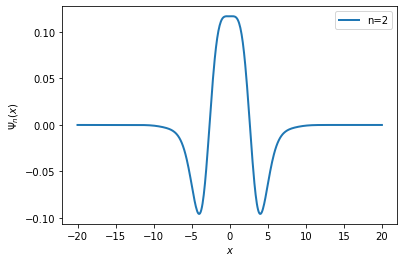

E = 12.325127075462559


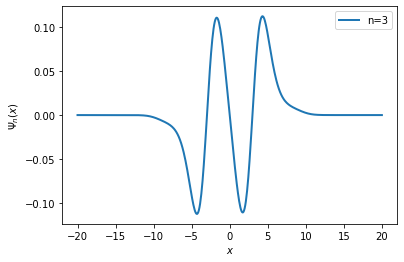

In [4]:
H = buildH(p0,Ec,El,Ej)
w, v = eigh(H)

nlowest = 4
print ('energies:', w[0:nlowest])

E0 = w[0]

import matplotlib.pyplot as plt
#plt.plot(xmesh, [Vpot(x) for x in xmesh], 'k-', lw=2)

for n in range(nlowest):
    print(f"E = {w[n]-w[0]}")
    plt.figure(n)
    plt.plot(xmesh, v[:,n],'-', label='n=%g'%(n), lw=2)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi_{n}(x)$')
    plt.legend()
    plt.show()

We make a plot out of the wave function

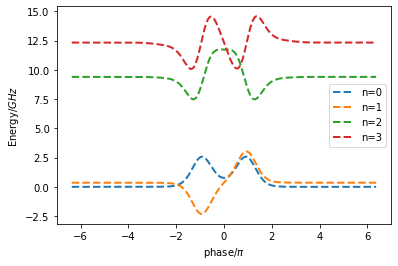

In [17]:
for n in range(nlowest):
    dE = w[n]-w[0]
    plt.plot(xmesh/jnp.pi, v[:,n]*20+dE,'--', label='n=%g'%(n), lw=2)
    
plt.xlabel('phase/$\pi$')
plt.ylabel('Energy/$GHz$')
plt.legend()
plt.show()

One of prominent features of Fluxonium is its large energy gap between computational qubit states and excited states. Due to this feature, we can project the wavefunction and Hamiltonian into the qubit computational subspace.

$$ P = |e\rangle\langle e|+|g\rangle\langle g|$$

And the Hamiltonian would become

$$ P\hat{H} P^T = P \hat{H}_h P^T - E_j[P\cos (\hat{\phi})P^T \cos (2\pi \frac{\phi_{ext}}{\phi_0})+  P\sin(\hat{\phi})P^T \sin (2\pi \frac{\phi_{ext}}{\phi_0})]$$

In this case, to save computational resource, each matrix can be stored precedingly.

In [18]:
P_sub = v[:,0:2]

CosMat = Ej*P_sub.T@jnp.diag(jnp.array([jnp.cos(x) for x in xmesh]))@P_sub
SinMat = Ej*P_sub.T@jnp.diag(jnp.array([jnp.sin(x) for x in xmesh]))@P_sub
H_harm = P_sub.T@(jnp.eye(Nmesh)*(Ec*4./(h*h))- 2*(jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h) # Kinetic energy
                 + jnp.diag(jnp.array([0.5*El*x**2 for x in xmesh])))@P_sub

In [66]:
print(SinMat)
print(H_harm)

[[ 1.00527992e-13  1.46614780e+00]
 [ 1.46614780e+00 -1.59603568e-13]]
[[3.37953423e+00 3.58755184e-14]
 [3.74958875e-14 4.03296522e+00]]


Til now we can try optmize control in this sub system, for example $\sigma_x$ gate

In [19]:
@jit
def A(t,p,t1):
    '''
    Control field phi, use Cosin series
    '''
    w = 2*jnp.pi/t1
    N1, = jnp.shape(p)
    ft = jnp.array([jnp.cos(w*i*t) for i in range(N1)])
    return p@ft+p0


def loss(t1,flat_p,H0,Cosphi,Sinphi,U_T):
    '''
    define the loss function, which is a pure function to speed up
    '''
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(H0)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix
    
    def H_sub(phi):
        return H0-(Cosphi*jnp.cos(2*jnp.pi*phi)+Sinphi*jnp.sin(2*jnp.pi*phi))

    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, 0:2,0:2]
#     print(U_F)
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/U_T.shape[0])**2)

def U_f(t1,flat_p,H0,Cosphi,Sinphi):
    
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(H0)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix
    
    def H_sub(phi):
        return H0-(Cosphi*jnp.cos(2*jnp.pi*phi)+Sinphi*jnp.sin(2*jnp.pi*phi))

    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
    return U_F

One way of optimize is with L-BFGS

In [21]:
from scipy.optimize import minimize

def GateOptimize_LBFGS(U_F, t1, H0,Cosphi,Sinphi, init_param,):
    '''
    Implementation with LBFGS
    '''
    loss_list = []
    
    loss_and_grad = jit(jax.value_and_grad(loss,(0,1)))
    
    def fun(p,*args):
        t0, p0 = p[0], p[1:]
        f, (gt,gp) = loss_and_grad(t0,p0,H0,Cosphi,Sinphi,U_F)
        gd = np.concatenate([np.array([gt]),gp])
        loss_list.append(f)
        print(f'loss = {f}',end="\r", flush=True)
        return f, gd
    
    results = minimize(fun,np.concatenate([np.array([t1]),init_param]), method='L-BFGS-B', jac=True, 
                       options={'gtol': 1e-07})
    return loss_list,results.x

With ADAM optimizer as well

In [8]:
def GateOptimize_adam(U_F, t1, init_param,H0,Cosphi,Sinphi, num_step=200, learning_rate=1.0):
    '''
    Get the best possible parameter
    psi_i: initial wave function
    psi_f: final wave function
    init_param: initial parameters
    '''
    opt_init, opt_update, get_params = optimizers.adam(
        learning_rate)  # Use adam optimizer
    loss_list = []
    
    import time
    
    def step_fun(step, opt_state, U_F):
        aug_params = get_params(opt_state)
        t1, flat_params = aug_params
        ta = time.time()
        value, grads = jit(jax.value_and_grad(
            loss, (0, 1)))(t1, flat_params, H0,Cosphi,Sinphi, U_F) # use jax autograd
        tb= time.time()
        print(f'value and grad cost {tb-ta} seconds')
        g_t, g_p = grads
        aug_grad = (g_t,g_p)
        opt_state = opt_update(step, aug_grad, opt_state)
        tc= time.time()
        print(f'value and grad cost {tc-tb} seconds')
        return value, opt_state

    aug_params = (t1,init_param)
    opt_state = opt_init(aug_params)

    # optimize
    for step in range(num_step):
        value, opt_state = step_fun(step, opt_state, U_F)
        loss_list.append(value)
        print('step {0} : loss is {1}'.format(
            step, value), end="\r", flush=True)

    print('final loss = ', value, flush=True)
    return loss_list, get_params(opt_state)


And now try the direct gradient descent of loss function

In [9]:
def GradientDecent(t0,p0,num=100,e=1e-6,lr=1e-3):
    loss_list = []
    l = 1.
    for n in range(num):
        l,(gt,gp) = jit(jax.value_and_grad(loss,(0,1)))(t0,p0,H_harm,CosMat,SinMat,sx)
        loss_list.append(l)
        t0 = t0 - lr*gt
        p0 = p0 - lr*gp
        print(f'step {n}, loss = {l}',end='\r',flush = True)
    return loss_list,(t0,p0)

Test the pretested coefficient from mathematica

In [22]:
tf = 1.40829
p_opt = jnp.array([0.242183, 0.22217, 0.167103, 0.0903744, 0.00976605, -0.0577118, \
-0.100383, -0.114443, -0.103836, -0.0778022, -0.0471902, -0.0209454, \
-0.00391343, 0.00351765, 0.00417113, 0.00201775])

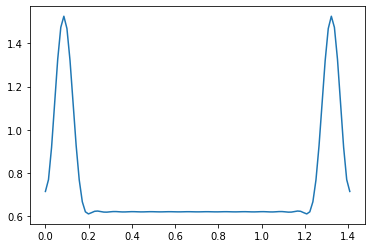

In [23]:
t_list = jnp.linspace(0.,tf,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,p_opt,tf)

plt.plot(t_list,A_list)
plt.show()

And we evaluate the loss

it's already better than our previous result. After this, we can do the LBFGS optimization

In [65]:
loss_list_LBFGS,res = GateOptimize_LBFGS(sx,tf,H_harm,CosMat,SinMat,p_opt)

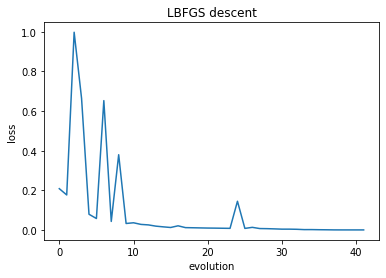

In [66]:
plt.plot([n for n in range(len(loss_list_LBFGS))],loss_list_LBFGS)
plt.title('LBFGS descent')
plt.ylabel('loss')
plt.xlabel('evolution')
plt.show()

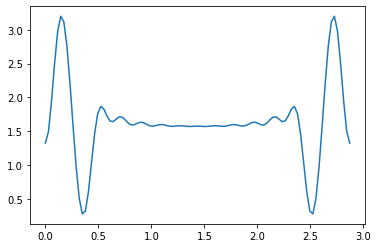

In [67]:
tfinal,pfinal = res[0],res[1:]
t_list = jnp.linspace(0.,tfinal,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,pfinal,tfinal)

plt.plot(t_list,A_list)
plt.show()

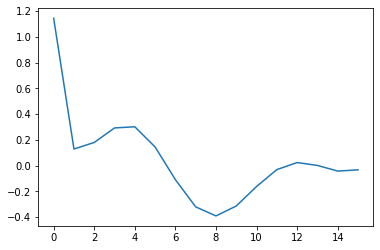

In [68]:
x = range(pfinal.shape[0])
plt.plot(x,pfinal)
plt.show()

We can substract dc component of 1

In [69]:
p_new = pfinal-jnp.array([1]+[0 for _ in range(pfinal.shape[0]-1)])

3.2871483313101635e-11


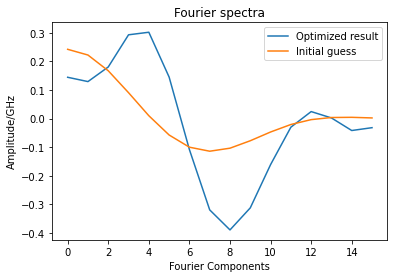

In [70]:
loss_sub = loss(tfinal,p_new,H_harm,CosMat,SinMat,sx)
print(loss_sub)

x = range(p_new.shape[0])
plt.plot(x,p_new,label='Optimized result')
plt.plot(x,p_opt,label='Initial guess')
plt.xlabel('Fourier Components')
plt.ylabel('Amplitude/GHz')
plt.title('Fourier spectra')
plt.legend()
plt.show()

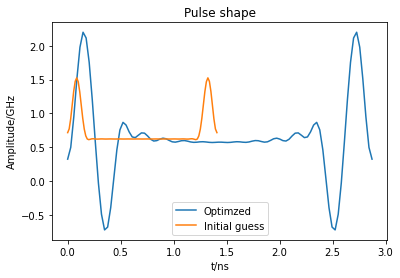

In [77]:
t_list = jnp.linspace(0.,tfinal,100)
t_list_2 = jnp.linspace(0.,tf,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,p_new,tfinal)
A_list_2 = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list_2,p_opt,tf)


plt.plot(t_list,A_list,label='Optimzed')
plt.plot(t_list_2,A_list_2,label='Initial guess')
plt.xlabel('t/ns')
plt.ylabel('Amplitude/GHz')
plt.title('Pulse shape')
plt.legend()

plt.show()

Like what we previously did, we can calculate the Hessian matrix of the system

In [31]:
from jax import jacrev
loss_p = lambda p: loss(tfinal,p,H_harm,CosMat,SinMat,sx)
Hess = jacrev(jacrev(loss_p))(p_new)
w0, v0 = jnp.linalg.eig(Hess)

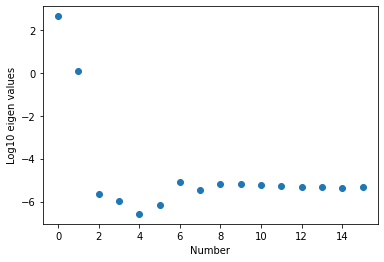

In [105]:
plt.plot(range(len(w0)),np.log10(np.abs(w0)),'o')
plt.xlabel('Number')
plt.ylabel('Log10 eigen values')

plt.show()

There are only two main eigenvalues

In [109]:
arglist = jnp.argsort(w0)[-2:]
main_eigen = w0[arglist]
main_vec = v0[:, arglist]

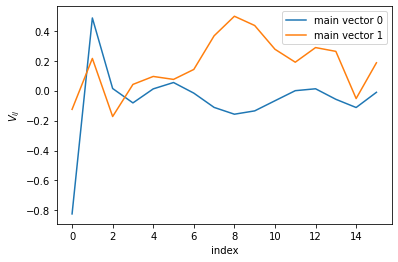

In [110]:
for i in range(p_new.shape[0]):
    if i in arglist:
        plt.plot(range(p_new.shape[0]), v0.real[:,i],label=f"main vector {i}")

plt.xlabel("index")
plt.ylabel("$V_{ij}$")

plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
plt.show()

Now we can test the performance in 

In [32]:
P_sub_four = v[:,0:4]

CosMatfour = Ej*P_sub_four.T@jnp.diag(jnp.array([jnp.cos(x) for x in xmesh]))@P_sub_four
SinMatfour = Ej*P_sub_four.T@jnp.diag(jnp.array([jnp.sin(x) for x in xmesh]))@P_sub_four
H_harmfour = P_sub_four.T@(jnp.eye(Nmesh)*(Ec*4./(h*h))- 2*(jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h) # Kinetic energy
                 + jnp.diag(jnp.array([0.5*El*x**2 for x in xmesh])))@P_sub_four

In [141]:
U_infour = U_f(tfinal,p_new,H_harmfour,CosMatfour,SinMatfour)

In [144]:
Transfer_mat = U_infour[0:2,2:4]
print(Transfer_mat)

[[-0.31918156+0.08727422j  0.65500276+0.03421828j]
 [-0.05327537-0.09866816j  0.39004357+0.19724466j]]


In [146]:
print(jnp.linalg.norm(Transfer_mat))
print(jnp.linalg.norm(U_infour[0:2,0:2]))

0.8621521158503518
1.1210235173158478


Sadly the excitation on the excited state is too strong making our presumption falsify. Because there are strong high frequency component exsisting

In [18]:
loss_preopt = loss(tf,p_opt,H_harmfour,CosMatfour,SinMatfour,sx)

In [19]:
print(loss_preopt)

0.22555675629317717


In [33]:
loss_list_LBFGS,res = GateOptimize_LBFGS(sx,tf,H_harmfour,CosMatfour,SinMatfour,p_opt)

In [34]:
jnp.linalg.norm(U_f(tf,p_opt,H_harmfour,CosMatfour,SinMatfour)[0:2,2:4])

DeviceArray(0.58151852, dtype=float64)

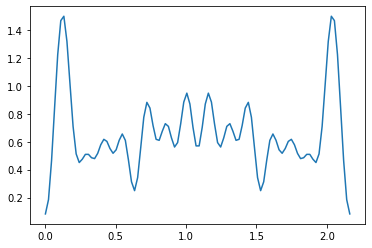

In [35]:
tfinal,pfinal = res[0],res[1:]
t_list = jnp.linspace(0.,tfinal,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,pfinal,tfinal)

plt.plot(t_list,A_list)
plt.show()

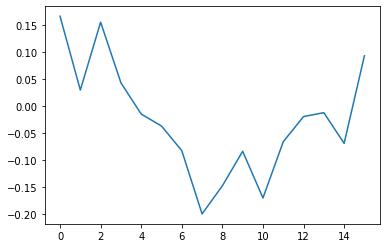

In [36]:
x = range(pfinal.shape[0])
plt.plot(x,pfinal)
plt.show()

In [37]:
def loss_hyper(t1,flat_p,H0,Cosphi,Sinphi,U_T,alpha=1e-5):
    '''
    define the loss function, which is a pure function to speed up
    '''
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(H0)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix
    
    def H_sub(phi):
        return H0-(Cosphi*jnp.cos(2*jnp.pi*phi)+Sinphi*jnp.sin(2*jnp.pi*phi))

    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, 0:2,0:2]
    U_d = res[-1,0:2,2:4]
    
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/U_T.shape[0])**2)+alpha*jnp.linalg.norm(U_d)

def GateOptimize_LBFGS_hyper(U_F, t1, H0,Cosphi,Sinphi, init_param,alpha=1e-5):
    '''
    Implementation with LBFGS
    '''
    loss_list = []
    
    loss_and_grad = jit(jax.value_and_grad(loss_hyper,(0,1)))
    
    def fun(p,*args):
        t0, p0 = p[0], p[1:]
        f, (gt,gp) = loss_and_grad(t0,p0,H0,Cosphi,Sinphi,U_F,alpha)
        gd = np.concatenate([np.array([gt]),gp])
        loss_list.append(f)
        print(f'loss = {f}',end="\r", flush=True)
        return f, gd
    
    results = minimize(fun,np.concatenate([np.array([t1]),init_param]), method='L-BFGS-B', jac=True, 
                       options={'gtol': 1e-07})
    return loss_list,results.x

In [50]:
loss_list_LBFGS_hyper,res_hyper = GateOptimize_LBFGS_hyper(sx,tf,H_harmfour,CosMatfour,SinMatfour,p_opt,alpha=1e-4)

In [46]:
U_infour = U_f(res_hyper[0],res_hyper[1:],H_harmfour,CosMatfour,SinMatfour)
print(U_infour)

[[-1.86467913e-04+1.16781395e-04j -3.25725889e-01-9.45464223e-01j
   2.18737612e-08+4.68813541e-08j  9.97139081e-08-4.34121808e-08j]
 [-3.25725889e-01-9.45464223e-01j -2.18828941e-04+2.28491412e-05j
   3.48043097e-08-2.27570434e-08j -1.09338489e-07-2.46844781e-08j]
 [ 2.29792665e-08+4.63835006e-08j  3.43296767e-08-2.39685900e-08j
   9.53307050e-01-2.01593720e-01j -1.59694734e-01+1.58313715e-01j]
 [ 9.81478672e-08-4.39421008e-08j -1.10696682e-07-2.37868318e-08j
  -1.59694735e-01+1.58313715e-01j -2.09865839e-01+9.51520198e-01j]]


In [51]:
print(jnp.linalg.norm(U_infour[0:2,2:4]))
print(loss(res_hyper[0],res_hyper[1:],H_harmfour,CosMatfour,SinMatfour,sx))

1.696975408220417e-07
1.0648282255942831e-10


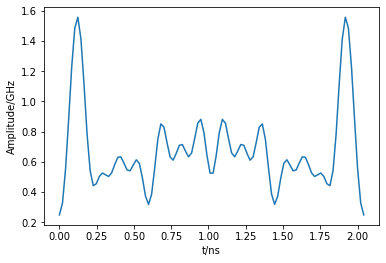

In [79]:
t_list = jnp.linspace(0.,res_hyper[0],100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,res_hyper[1:],res_hyper[0])

fig, ax = plt.subplots(2,1)
ax[0].plot(t_list,A_list)
plt.xlabel('t/ns')
plt.ylabel('Amplitude/GHz')

plt.show()

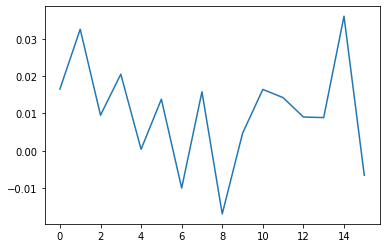

In [54]:
x = range(res_hyper[1:].shape[0])
plt.plot(x,res_hyper[1:]-pfinal)
plt.show()

In [55]:
print(U_infour[0:2,2:4])

[[ 2.18737612e-08+4.68813541e-08j  9.97139081e-08-4.34121808e-08j]
 [ 3.48043097e-08-2.27570434e-08j -1.09338489e-07-2.46844781e-08j]]
